<a href="https://colab.research.google.com/github/Elshraby/DeepAerofoil/blob/main/AeroDyn_CNN_05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1: Regression Model


In [39]:
import torch
from torch import nn
print(f"Torch version: {torch.__version__}")

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Torch version: 2.5.0+cu121
Using device: cpu


In [40]:
import requests
import zipfile
from pathlib import Path

# Download Airfoils data
with open("Airfoils.zip", "wb") as f:
    request = requests.get("https://github.com/Elshraby/meine-repo/raw/refs/heads/main/data/Airfoils.zip")
    print("Downloading Airfoils Data...")
    f.write(request.content)

# Unzip Airfoil data
with zipfile.ZipFile("FoilsData.zip", "r") as zip_ref:
    print("Unzipping airfoils data...")
    zip_ref.extractall()

Unzipping airfoils data...


In [41]:
import pandas as pd
df = pd.read_csv('RegData.csv')
df.head()

,name,y_U1,y_U2,y_U3,y_U4,y_U5,y_U6,y_U7,y_U8,y_U9,...,y_L4,y_L5,y_L6,y_L7,y_L8,y_L9,angle,cd,cl,cm
0,2032c,0.078,0.1013,0.1048,0.1002,0.0905,0.0771,0.061,0.0428,0.0229,...,0.0385,0.0386,0.035,0.0286,0.0202,0.01,-8.75,0.09761,-0.1581,-0.0262
1,2032c,0.078,0.1013,0.1048,0.1002,0.0905,0.0771,0.061,0.0428,0.0229,...,0.0385,0.0386,0.035,0.0286,0.0202,0.01,-8.50,0.09468,-0.1536,-0.0262
2,2032c,0.078,0.1013,0.1048,0.1002,0.0905,0.0771,0.061,0.0428,0.0229,...,0.0385,0.0386,0.035,0.0286,0.0202,0.01,-8.25,0.10671,-0.2407,-0.0219
3,2032c,0.078,0.1013,0.1048,0.1002,0.0905,0.0771,0.061,0.0428,0.0229,...,0.0385,0.0386,0.035,0.0286,0.0202,0.01,-8.00,0.10247,-0.2303,-0.0213
4,2032c,0.078,0.1013,0.1048,0.1002,0.0905,0.0771,0.061,0.0428,0.0229,...,0.0385,0.0386,0.035,0.0286,0.0202,0.01,-7.75,0.09947,-0.2229,-0.0215


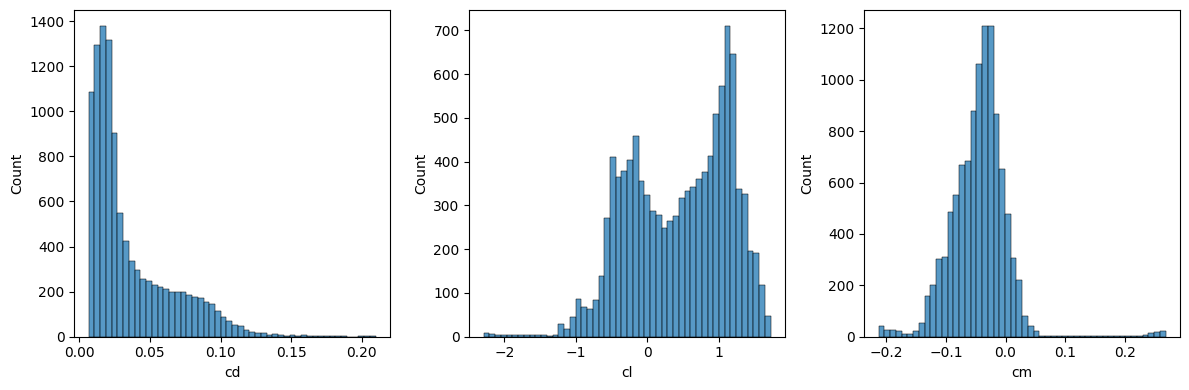

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

fig = plt.figure(figsize=(12, 4))

fig.add_subplot(1, 3, 1)
sns.histplot(df['cd'], bins=50)

fig.add_subplot(1, 3, 2)
sns.histplot(df['cl'], bins=50)

fig.add_subplot(1, 3, 3)
sns.histplot(df['cm'], bins=50)

plt.tight_layout()

In [43]:
from sklearn.model_selection import train_test_split
# Define the features and target variables
features = ['y_U1', 'y_U2', 'y_U3', 'y_U4', 'y_U5', 'y_U6', 'y_U7', 'y_U8', 'y_U9',
            'y_L1', 'y_L2', 'y_L3', 'y_L4', 'y_L5', 'y_L6', 'y_L7', 'y_L8', 'y_L9',
            'angle']
targets = ['cl', 'cd', 'cm']

# Split the data into training, validation, and test sets
features_train, features_temp, targets_train, targets_temp = train_test_split(df[features], df[targets], test_size=0.3, random_state=42)
features_val, features_test, targets_val, targets_test = train_test_split(features_temp, targets_temp, test_size=0.5, random_state=42)

In [44]:
import torch
from torch.utils.data import DataLoader, TensorDataset

# Prepare PyTorch datasets and loaders for the neural network
batch_size = 32
train_dataset = TensorDataset(torch.tensor(features_train.values, dtype=torch.float32),
                              torch.tensor(targets_train.values, dtype=torch.float32))
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

val_dataset = TensorDataset(torch.tensor(features_val.values, dtype=torch.float32),
                              torch.tensor(targets_val.values, dtype=torch.float32))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

In [45]:
len(features)

19

In [46]:
import torch.nn as nn
import torch.optim as optim

# Neural Network for Regression
class RegressionNN(nn.Module):
    def __init__(self):
        super(RegressionNN, self).__init__()
        self.fc1 = nn.Linear(len(features), 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 3)  # Output size is 3 for 'cl', 'cd', and 'cm'

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Initialize model, loss function, and optimizer
model = RegressionNN().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [47]:
'''
# Neural Network Training
torch.manual_seed(42)

num_epochs = 500
model.train()
for epoch in range(num_epochs):
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()

    # Testing step
    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss /= len(val_loader)
    if epoch % 50 == 0:
      print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")
'''

'\n# Neural Network Training\ntorch.manual_seed(42)\n\nnum_epochs = 500\nmodel.train()\nfor epoch in range(num_epochs):\n    for inputs, targets in train_loader:\n        inputs, targets = inputs.to(device), targets.to(device)\n        optimizer.zero_grad()\n        outputs = model(inputs)\n        loss = criterion(outputs, targets)\n        loss.backward()\n        optimizer.step()\n\n    # Testing step\n    val_loss = 0\n    with torch.no_grad():\n        for inputs, targets in val_loader:\n            inputs, targets = inputs.to(device), targets.to(device)\n            outputs = model(inputs)\n            val_loss += criterion(outputs, targets).item()\n    val_loss /= len(val_loader)\n    if epoch % 50 == 0:\n      print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")\n'

In [48]:
torch.manual_seed(42)

train_losses = []
val_losses = []

num_epochs = 801
for epoch in range(num_epochs):
    epoch_train_loss = 0
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        epoch_train_loss += loss.item()

    epoch_train_loss /= len(train_loader)
    train_losses.append(epoch_train_loss)

    val_loss = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            val_loss += criterion(outputs, targets).item()
    val_loss /= len(val_loader)
    val_losses.append(val_loss)
    if epoch % 50 == 0:
      print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {val_loss:.4f}")

Epoch 1/1001, Validation Loss: 0.0136
Epoch 51/1001, Validation Loss: 0.0035
Epoch 101/1001, Validation Loss: 0.0015
Epoch 151/1001, Validation Loss: 0.0013
Epoch 201/1001, Validation Loss: 0.0009
Epoch 251/1001, Validation Loss: 0.0007
Epoch 301/1001, Validation Loss: 0.0009
Epoch 351/1001, Validation Loss: 0.0007
Epoch 401/1001, Validation Loss: 0.0006
Epoch 451/1001, Validation Loss: 0.0005
Epoch 501/1001, Validation Loss: 0.0006
Epoch 551/1001, Validation Loss: 0.0005
Epoch 601/1001, Validation Loss: 0.0005
Epoch 651/1001, Validation Loss: 0.0006
Epoch 701/1001, Validation Loss: 0.0005
Epoch 751/1001, Validation Loss: 0.0004
Epoch 801/1001, Validation Loss: 0.0004
Epoch 851/1001, Validation Loss: 0.0006
Epoch 901/1001, Validation Loss: 0.0005
Epoch 951/1001, Validation Loss: 0.0005
Epoch 1001/1001, Validation Loss: 0.0006


In [49]:
# Prepare test data and evaluate models
features_test_tensor = torch.tensor(features_test.values, dtype=torch.float32).to(device)
targets_test_tensor = torch.tensor(targets_test.values, dtype=torch.float32).to(device)

In [50]:
# Make predictions
model.eval()
with torch.no_grad():
  targets_pred_nn = model(features_test_tensor)

In [51]:
targets_pred_nn[:10]

tensor([[-0.5016,  0.0458, -0.0653],
        [-0.3256,  0.0194, -0.0380],
        [-0.8013,  0.0290, -0.0154],
        [ 0.1842,  0.0128, -0.0078],
        [ 0.3093,  0.0092, -0.0271],
        [ 0.7864,  0.0141, -0.0761],
        [ 0.8472,  0.0234, -0.0350],
        [ 1.2956,  0.0257, -0.0258],
        [ 0.9761,  0.0240, -0.0232],
        [ 0.8606,  0.0213, -0.0251]])

In [52]:
# Compare first 10 model preds and test labels
print(f"Predictions: {targets_pred_nn[:10]}\nLabels: {targets_test_tensor[:10]}")

Predictions: tensor([[-0.5016,  0.0458, -0.0653],
        [-0.3256,  0.0194, -0.0380],
        [-0.8013,  0.0290, -0.0154],
        [ 0.1842,  0.0128, -0.0078],
        [ 0.3093,  0.0092, -0.0271],
        [ 0.7864,  0.0141, -0.0761],
        [ 0.8472,  0.0234, -0.0350],
        [ 1.2956,  0.0257, -0.0258],
        [ 0.9761,  0.0240, -0.0232],
        [ 0.8606,  0.0213, -0.0251]])
Labels: tensor([[-0.5229,  0.0507, -0.0612],
        [-0.3548,  0.0160, -0.0258],
        [-0.8025,  0.0248, -0.0110],
        [ 0.1874,  0.0084, -0.0109],
        [ 0.2896,  0.0077, -0.0305],
        [ 0.8089,  0.0117, -0.0793],
        [ 0.8789,  0.0148, -0.0433],
        [ 1.2402,  0.0235, -0.0223],
        [ 0.9407,  0.0257, -0.0159],
        [ 0.8508,  0.0144, -0.0237]])


In [53]:
import numpy as np
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# Calculate RMSE for regression model
rmse_nn = np.sqrt(mean_squared_error(targets_test_tensor, targets_pred_nn))
# R2 scores for Neural Network
r2_nn = r2_score(targets_test_tensor, targets_pred_nn)
print(f"RMSE for Neural Network: {rmse_nn}")
print(f"R2 Score for Neural Network: {r2_nn}")

RMSE for Neural Network: 0.02563749998807907
R2 Score for Neural Network: 0.9691971581899287


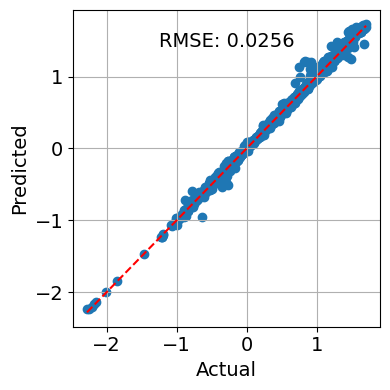

In [54]:
# Visualization of results
fig, axs = plt.subplots(1, 1, figsize=(4, 4))
model_names = ['Neural Network']
predictions = [targets_pred_nn]
rmses = [rmse_nn]

letters = ['a']

for i in range(len(model_names)):
    x = targets_test_tensor[:, 0].cpu().detach().numpy()
    y = predictions[i][:, 0].cpu().detach().numpy()
    axs.scatter(x, y)
    axs.plot([targets_test_tensor.min(), targets_test_tensor.max()], [targets_test_tensor.min(), targets_test_tensor.max()], 'r--')
    axs.set_xlabel('Actual', fontsize=14)
    axs.set_ylabel('Predicted', fontsize=14)
    axs.tick_params(axis='both', labelsize=14)  # Set tick font size
    axs.text(0.5, 0.9, f"RMSE: {rmses[i]:.4f}", fontsize=14, ha='center', va='center', transform=axs.transAxes)
    axs.grid()

plt.tight_layout()
plt.show()

### More Visualizaion for the Reslts

In [55]:
import torch
import numpy as np
from sklearn.metrics import mean_absolute_error

def evaluate_model(model, data_loader, device):
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)

            # Move predictions and targets to CPU and convert to numpy
            predictions = outputs.cpu().numpy()
            targets = targets.cpu().numpy()

            all_predictions.append(predictions)
            all_targets.append(targets)

    # Concatenate all batches
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_targets = np.concatenate(all_targets, axis=0)

    # Calculate MAE for each output separately
    mae_cl = mean_absolute_error(all_targets[:, 0], all_predictions[:, 0])
    mae_cd = mean_absolute_error(all_targets[:, 1], all_predictions[:, 1])
    mae_cm = mean_absolute_error(all_targets[:, 2], all_predictions[:, 2])

    return {
        'mae_cl': mae_cl,
        'mae_cd': mae_cd,
        'mae_cm': mae_cm
    }

# Calculate MAE for validation set
val_metrics = evaluate_model(model, val_loader, device)
print("\nValidation Set Metrics:")
print(f"MAE for cl: {val_metrics['mae_cl']:.6f}")
print(f"MAE for cd: {val_metrics['mae_cd']:.6f}")
print(f"MAE for cm: {val_metrics['mae_cm']:.6f}")

# Calculate MAE for test set
test_dataset = TensorDataset(torch.tensor(features_test.values, dtype=torch.float32),
                           torch.tensor(targets_test.values, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

test_metrics = evaluate_model(model, test_loader, device)
print("\nTest Set Metrics:")
print(f"MAE for cl: {test_metrics['mae_cl']:.6f}")
print(f"MAE for cd: {test_metrics['mae_cd']:.6f}")
print(f"MAE for cm: {test_metrics['mae_cm']:.6f}")


Validation Set Metrics:
MAE for cl: 0.024438
MAE for cd: 0.005527
MAE for cm: 0.005728

Test Set Metrics:
MAE for cl: 0.025348
MAE for cd: 0.005349
MAE for cm: 0.005602


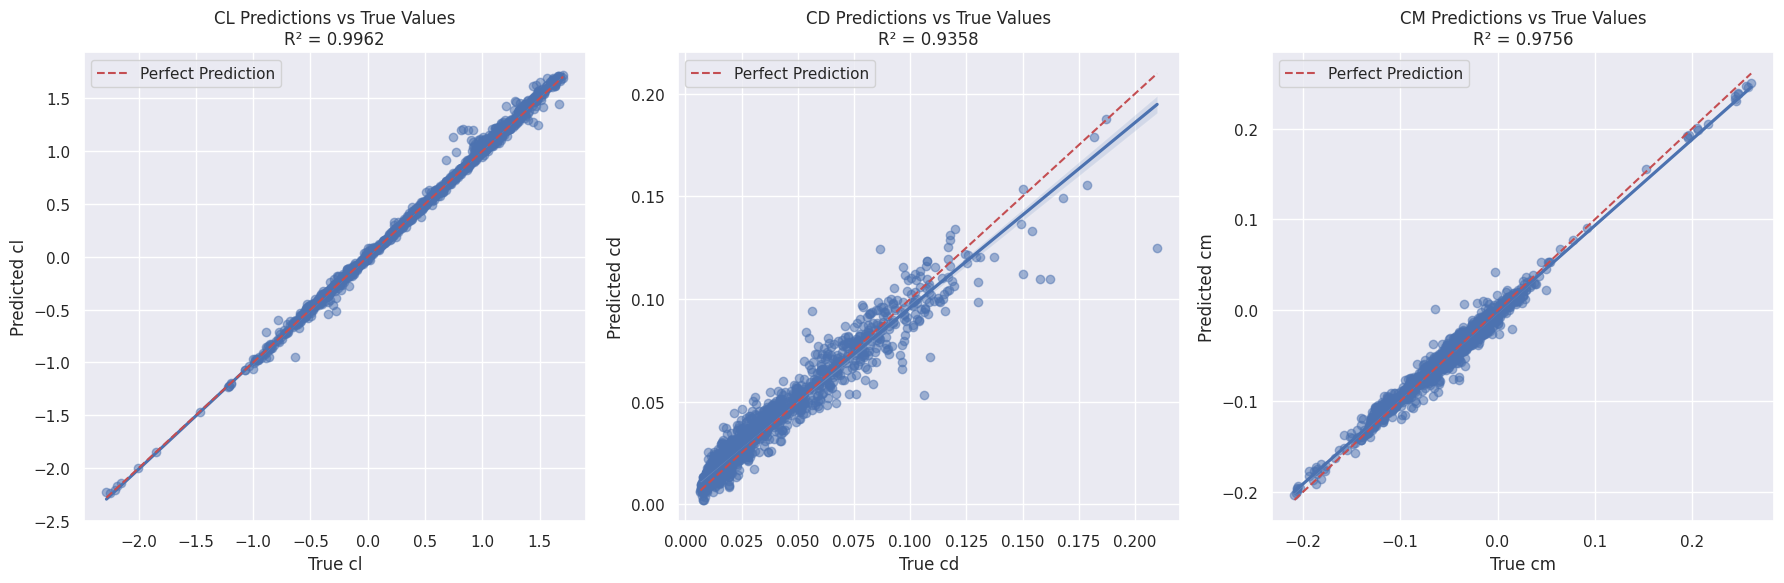

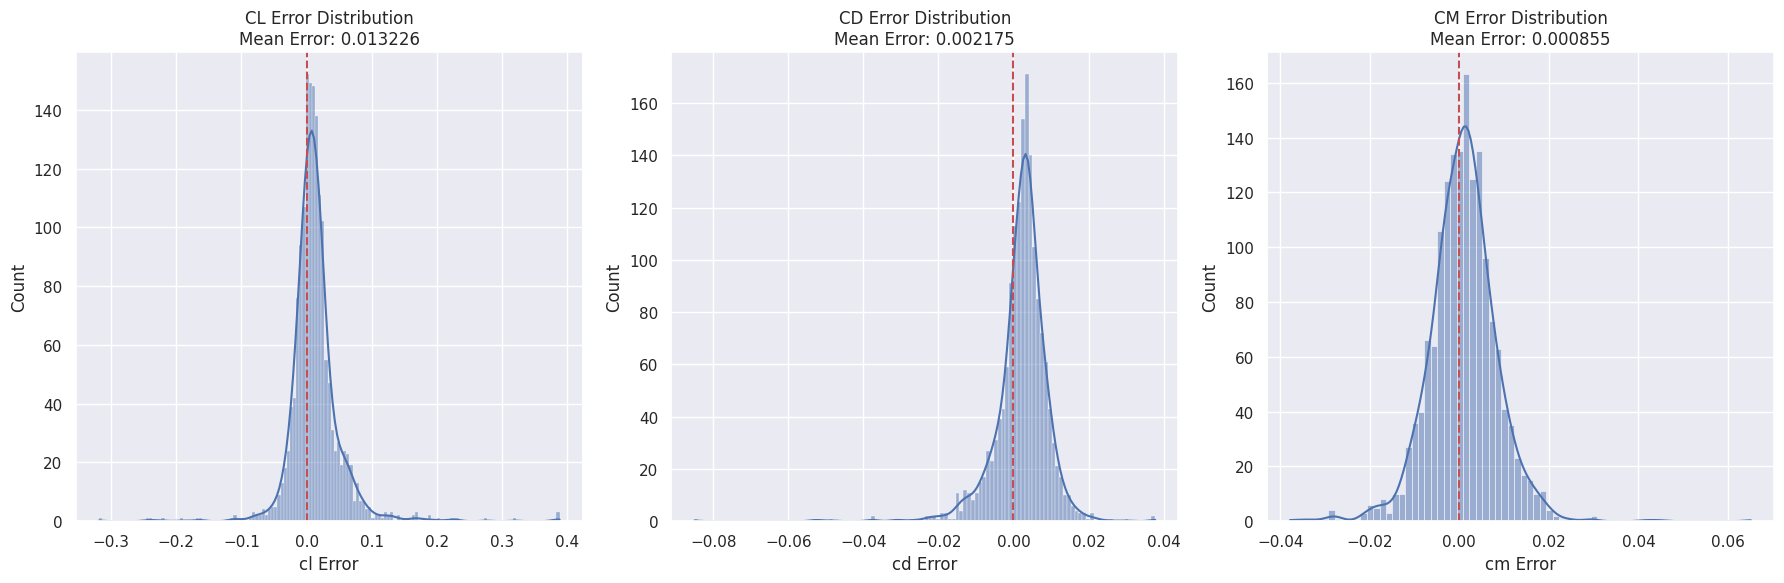

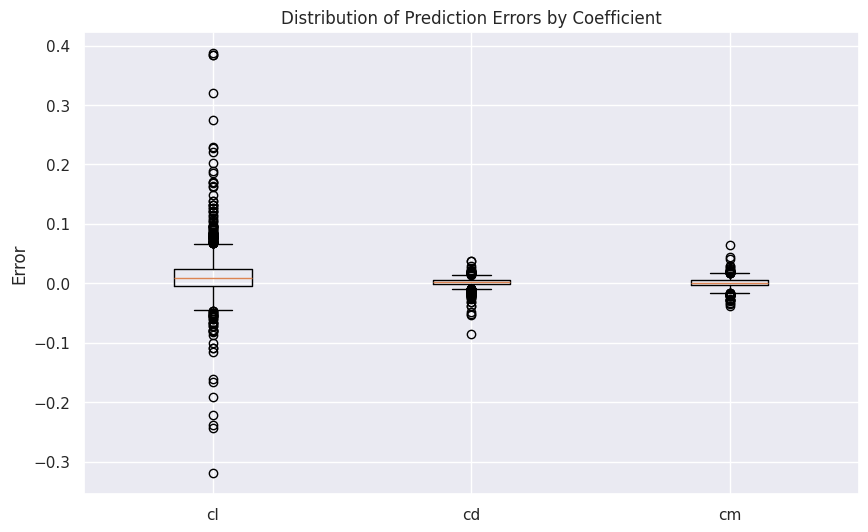

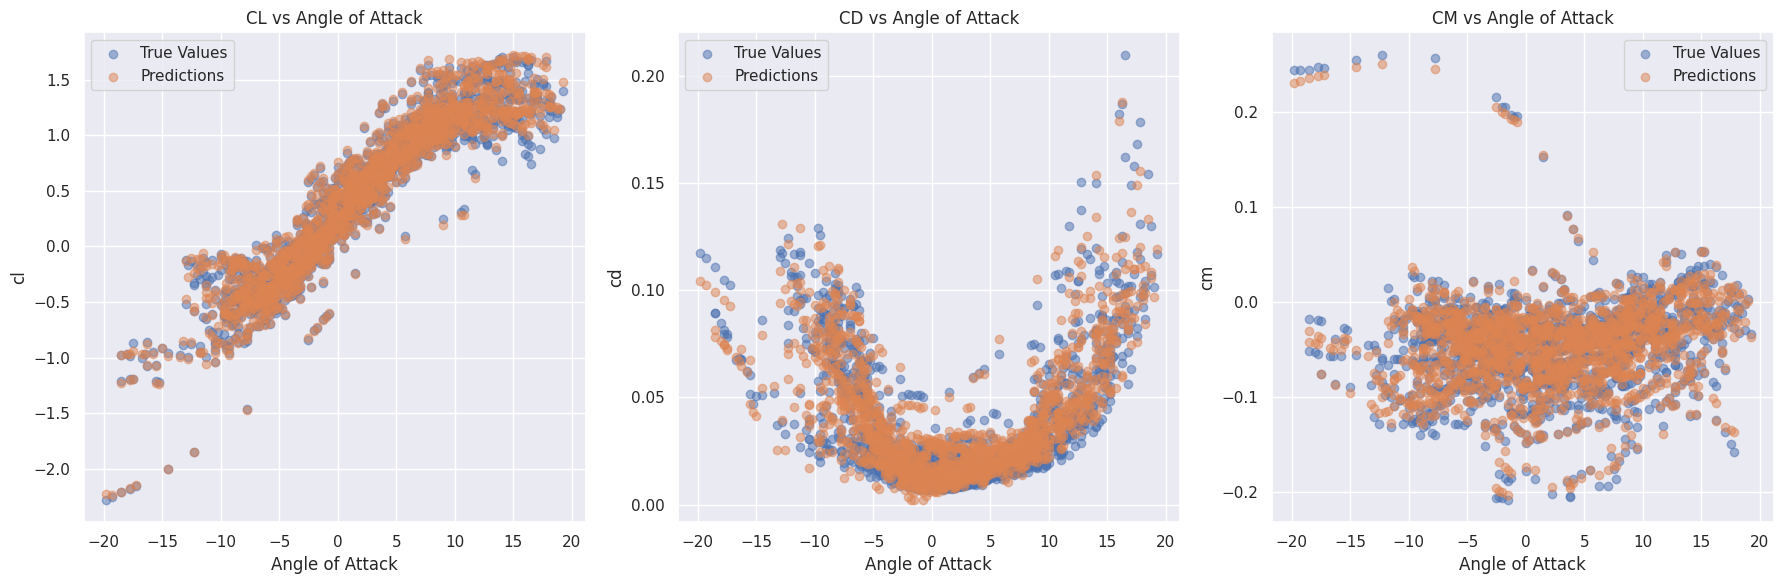

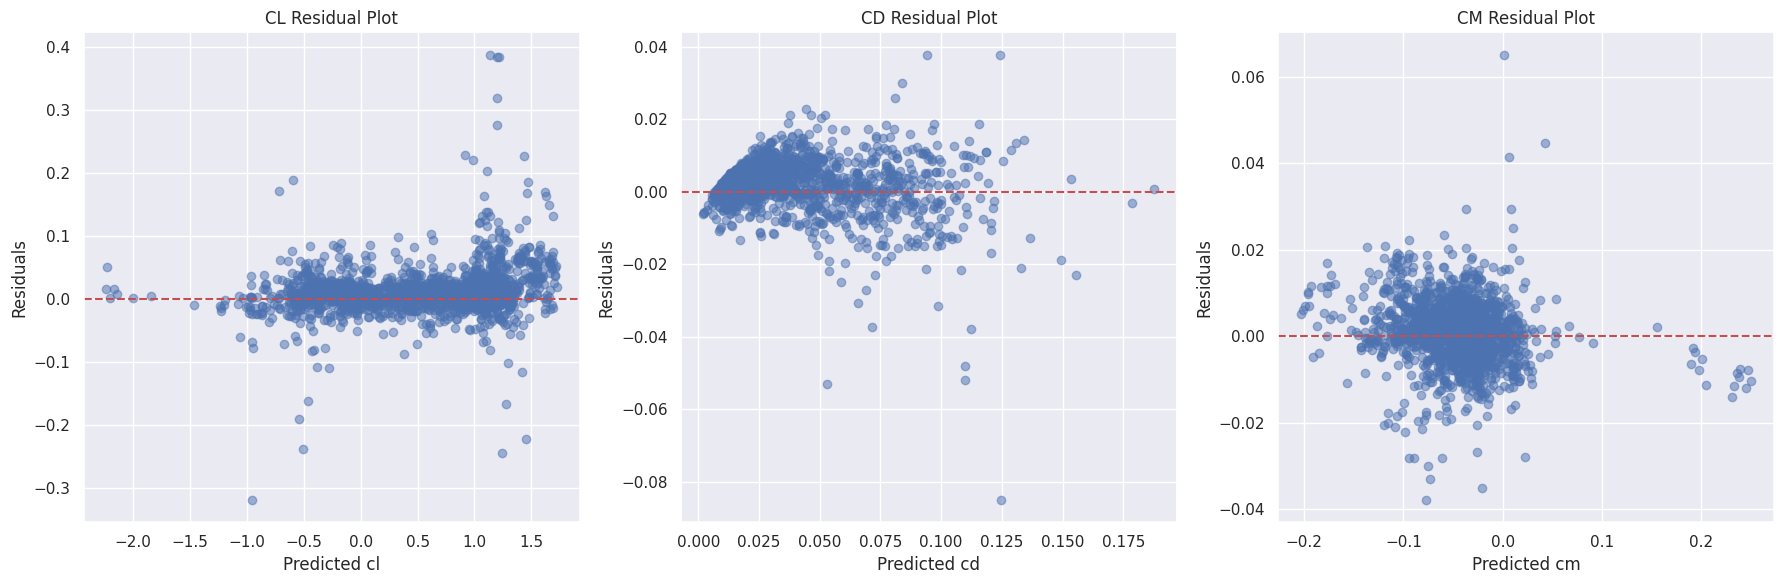

In [57]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score
sns.set_theme()

def create_visualization_suite(model, test_loader, device, features_test, targets_test):
    # Get predictions for test set
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = model(inputs)
            predictions = outputs.cpu().numpy()
            targets = targets.numpy()
            all_predictions.append(predictions)
            all_targets.append(targets)

    predictions = np.concatenate(all_predictions, axis=0)
    true_values = np.concatenate(all_targets, axis=0)

    # 1. Scatter plots with regression lines for each coefficient
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    coefficients = ['cl', 'cd', 'cm']

    for i, (coef, ax) in enumerate(zip(coefficients, axes)):
        sns.regplot(x=true_values[:, i], y=predictions[:, i], ax=ax, scatter_kws={'alpha':0.5})
        ax.plot([true_values[:, i].min(), true_values[:, i].max()],
                [true_values[:, i].min(), true_values[:, i].max()],
                'r--', label='Perfect Prediction')
        ax.set_xlabel(f'True {coef}')
        ax.set_ylabel(f'Predicted {coef}')
        ax.set_title(f'{coef.upper()} Predictions vs True Values\nR² = {r2_score(true_values[:, i], predictions[:, i]):.4f}')
        ax.legend()

    plt.tight_layout()
    plt.show()

    # 2. Error Distribution Histogram
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (coef, ax) in enumerate(zip(coefficients, axes)):
        errors = predictions[:, i] - true_values[:, i]
        sns.histplot(errors, kde=True, ax=ax)
        ax.axvline(x=0, color='r', linestyle='--')
        ax.set_xlabel(f'{coef} Error')
        ax.set_ylabel('Count')
        ax.set_title(f'{coef.upper()} Error Distribution\nMean Error: {np.mean(errors):.6f}')

    plt.tight_layout()
    plt.show()

    # 3. Box Plot of Prediction Errors
    fig, ax = plt.subplots(figsize=(10, 6))
    errors = predictions - true_values
    plt.boxplot([errors[:, i] for i in range(3)], labels=coefficients)
    plt.title('Distribution of Prediction Errors by Coefficient')
    plt.ylabel('Error')
    plt.grid(True)
    plt.show()

    # 4. Angle of Attack vs Coefficients Plot
    angles = features_test['angle'].values
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (coef, ax) in enumerate(zip(coefficients, axes)):
        ax.scatter(angles, true_values[:, i], alpha=0.5, label='True Values')
        ax.scatter(angles, predictions[:, i], alpha=0.5, label='Predictions')
        ax.set_xlabel('Angle of Attack')
        ax.set_ylabel(coef)
        ax.set_title(f'{coef.upper()} vs Angle of Attack')
        ax.legend()
        ax.grid(True)

    plt.tight_layout()
    plt.show()

    # 5. Learning Curves (requires training history)
    def plot_learning_curves(train_losses, val_losses):
        plt.figure(figsize=(10, 6))
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Learning Curves')
        plt.legend()
        plt.grid(True)
        plt.show()

    # 6. Residual Plot
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (coef, ax) in enumerate(zip(coefficients, axes)):
        residuals = predictions[:, i] - true_values[:, i]
        ax.scatter(predictions[:, i], residuals, alpha=0.5)
        ax.axhline(y=0, color='r', linestyle='--')
        ax.set_xlabel(f'Predicted {coef}')
        ax.set_ylabel('Residuals')
        ax.set_title(f'{coef.upper()} Residual Plot')
        ax.grid(True)

    plt.tight_layout()
    plt.show()

# To use the visualization suite, you would call:
test_dataset = TensorDataset(torch.tensor(features_test.values, dtype=torch.float32),
                           torch.tensor(targets_test.values, dtype=torch.float32))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

create_visualization_suite(model, test_loader, device, features_test, targets_test)

#Part 2: Convolutional Neural Network Model

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

class AirfoilDataset(Dataset):
    def __init__(self, csv_file, transform=None):
        self.data = pd.read_csv(csv_file)
        self.transform = transform

        # Extract x, y coordinates
        self.x_coords = self.data['x_coords'].apply(lambda x: np.array(x.split()).astype(float)).tolist()
        self.y_coords = self.data['y_coords'].apply(lambda x: np.array(x.split()).astype(float)).tolist()

        # Extract input parameters
        self.aoa = self.data['angle'].values
        self.re = self.data['reynolds'].values

        # Extract target variables
        self.cl = self.data['cl'].values
        self.cd = self.data['cd'].values
        self.cm = self.data['cm'].values

        # Normalize input and target variables
        self.input_scaler = MinMaxScaler()
        self.input_params = self.input_scaler.fit_transform(np.column_stack((self.aoa, self.re)))

        self.output_scaler = MinMaxScaler()
        self.targets = self.output_scaler.fit_transform(np.column_stack((self.cl, self.cd, self.cm)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        x = np.array(self.x_coords[idx])
        y = np.array(self.y_coords[idx])

        # Create 2D image from x, y coordinates
        image = np.column_stack((x, y))
        image = image.reshape(1, len(x), 2)  # Dynamic sizing based on the number of points

        if self.transform:
            image = self.transform(image)

        input_params = self.input_params[idx]

        return image, input_params, self.targets[idx]

    def augment_data(self, x, y):
        # Add small random noise
        noise = np.random.normal(0, 0.001, x.shape)
        x += noise
        y += noise

        # Slightly rotate
        angle = np.random.uniform(-2, 2)
        rad = np.deg2rad(angle)
        rotation_matrix = np.array([[np.cos(rad), -np.sin(rad)],
                                    [np.sin(rad), np.cos(rad)]])
        rotated = np.dot(np.column_stack((x, y)), rotation_matrix)
        x, y = rotated[:, 0], rotated[:, 1]

        return x, y

def collate_fn(batch):
    images = [item[0] for item in batch]
    input_params = [item[1] for item in batch]
    targets = [item[2] for item in batch]

    # Pad images to the maximum size in the batch
    max_len = max(img.shape[1] for img in images)
    padded_images = [np.pad(img, ((0, 0), (0, max_len - img.shape[1]), (0, 0)), mode='constant') for img in images]

    # Stack the padded images, input parameters, and targets
    padded_images = np.stack(padded_images)
    input_params = np.stack(input_params)
    targets = np.stack(targets)

    return torch.FloatTensor(padded_images), torch.FloatTensor(input_params), torch.FloatTensor(targets)

In [76]:
class ImprovedAirfoilCNN(nn.Module):
    def __init__(self, dropout_rate=0.3):
        super(ImprovedAirfoilCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(64)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(128)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(256)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc1 = nn.Linear(256 + 2, 128)  # +2 for AoA and Re
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 3)  # 3 output variables: cl, cd, cm
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, params):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.relu(self.bn3(self.conv3(x)))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = torch.cat((x, params), dim=1)  # Concatenate AoA and Re
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [77]:
def train_model(model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    train_losses = []
    val_losses = []
    learning_rates = []  # Track learning rates

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        for inputs, params, targets in train_loader:
            inputs, params, targets = inputs.to(device), params.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs, params)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        train_loss = running_loss / len(train_loader)
        train_losses.append(train_loss)

        # Validation phase
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, params, targets in val_loader:
                inputs, params, targets = inputs.to(device), params.to(device), targets.to(device)
                outputs = model(inputs, params)
                loss = criterion(outputs, targets)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_losses.append(val_loss)

        # Track learning rate
        current_lr = optimizer.param_groups[0]['lr']
        learning_rates.append(current_lr)

        scheduler.step(val_loss)

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}')

    return train_losses, val_losses, learning_rates

In [78]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import r2_score
from scipy import stats

def plot_loss_curves_with_lr(train_losses, val_losses, learning_rates):
    """Plot training/validation losses with learning rate changes."""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), height_ratios=[2, 1])

    # Plot losses
    ax1.plot(train_losses, label='Training Loss', color='blue')
    ax1.plot(val_losses, label='Validation Loss', color='red')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Training and Validation Losses Over Time')
    ax1.legend()
    ax1.grid(True)

    # Plot learning rate
    ax2.semilogy(learning_rates, color='green')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Learning Rate')
    ax2.set_title('Learning Rate Schedule')
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

def plot_regression_analysis(predictions, targets, coefficient_names):
    """Create detailed regression analysis plots for each coefficient."""
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (ax, coef) in enumerate(zip(axes, coefficient_names)):
        # Calculate R² score
        r2 = r2_score(targets[:, i], predictions[:, i])

        # Create scatter plot with density
        sns.regplot(x=targets[:, i], y=predictions[:, i], ax=ax, scatter_kws={'alpha':0.5})

        # Add perfect prediction line
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()]),
        ]
        ax.plot(lims, lims, 'r--', alpha=0.75, zorder=0)

        # Add R² score and other statistics
        ax.text(0.05, 0.95, f'R² = {r2:.4f}',
                transform=ax.transAxes, fontsize=10,
                verticalalignment='top')

        ax.set_xlabel(f'Actual {coef}')
        ax.set_ylabel(f'Predicted {coef}')
        ax.set_title(f'{coef} Prediction Analysis')
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_error_distribution(predictions, targets, coefficient_names):
    """Plot error distribution histograms for each coefficient."""
    errors = predictions - targets
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (ax, coef) in enumerate(zip(axes, coefficient_names)):
        # Create histogram of errors
        sns.histplot(errors[:, i], kde=True, ax=ax)

        # Add statistics
        mean_error = np.mean(errors[:, i])
        std_error = np.std(errors[:, i])

        ax.axvline(mean_error, color='r', linestyle='--', label=f'Mean: {mean_error:.4f}')
        ax.axvline(mean_error + std_error, color='g', linestyle=':',
                  label=f'±1 SD: {std_error:.4f}')
        ax.axvline(mean_error - std_error, color='g', linestyle=':')

        ax.set_xlabel(f'{coef} Error')
        ax.set_ylabel('Count')
        ax.set_title(f'{coef} Error Distribution')
        ax.legend()

    plt.tight_layout()
    plt.show()

def plot_performance_heatmap(predictions, targets, input_params, coefficient_names):
    """Create heatmap showing prediction error vs input parameters."""
    errors = np.abs(predictions - targets)

    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    for i, (ax, coef) in enumerate(zip(axes, coefficient_names)):
        # Create 2D histogram
        h = ax.hist2d(input_params[:, 0], input_params[:, 1], weights=errors[:, i],
                     bins=20, cmap='YlOrRd')

        plt.colorbar(h[3], ax=ax, label=f'|Error| in {coef}')
        ax.set_xlabel('Angle of Attack')
        ax.set_ylabel('Reynolds Number')
        ax.set_title(f'{coef} Error vs Input Parameters')

    plt.tight_layout()
    plt.show()

# Usage example:
def create_all_visualizations(model_results):
    """
    Create all visualizations for the model results.

    Parameters:
    model_results: dict containing:
        - train_losses: list of training losses
        - val_losses: list of validation losses
        - learning_rates: list of learning rates
        - predictions: numpy array of model predictions
        - targets: numpy array of actual targets
        - input_params: numpy array of input parameters
    """
    # Plot training curves
    plot_loss_curves_with_lr(
        model_results['train_losses'],
        model_results['val_losses'],
        model_results['learning_rates']
    )

    # Plot regression analysis
    coefficient_names = ['CL', 'CD', 'CM']
    plot_regression_analysis(
        model_results['predictions'],
        model_results['targets'],
        coefficient_names
    )

    # Plot error distributions
    plot_error_distribution(
        model_results['predictions'],
        model_results['targets'],
        coefficient_names
    )

    # Plot performance heatmap
    plot_performance_heatmap(
        model_results['predictions'],
        model_results['targets'],
        model_results['input_params'],
        coefficient_names
    )

Epoch [1/3], Train Loss: 0.0282, Val Loss: 0.0140
Epoch [2/3], Train Loss: 0.0149, Val Loss: 0.0096
Epoch [3/3], Train Loss: 0.0113, Val Loss: 0.0074


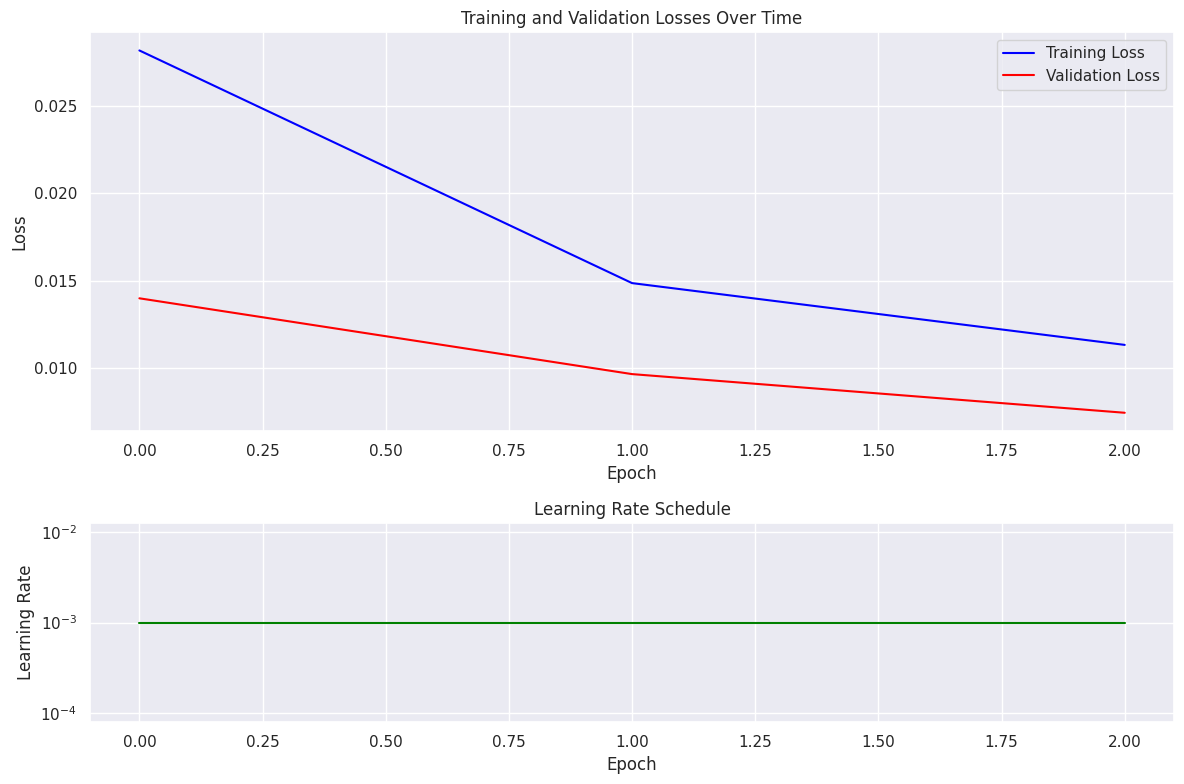

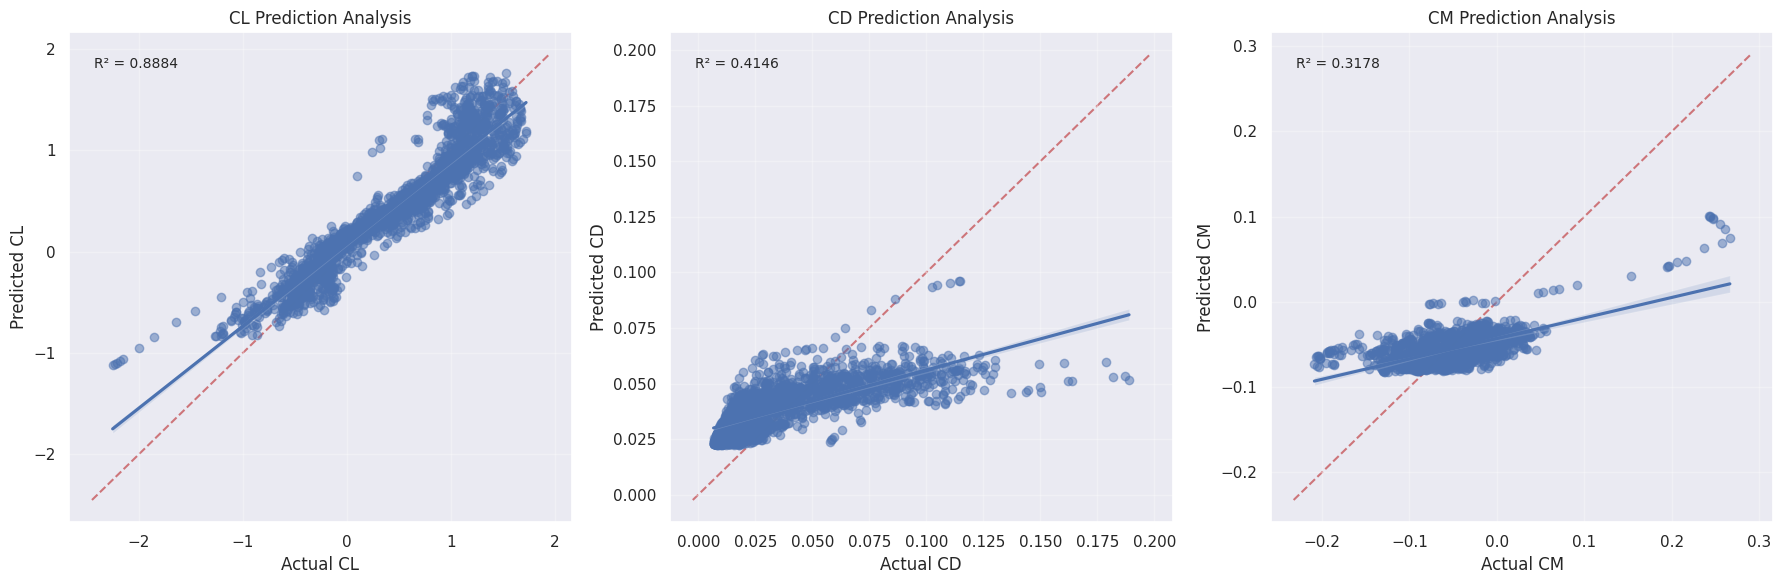

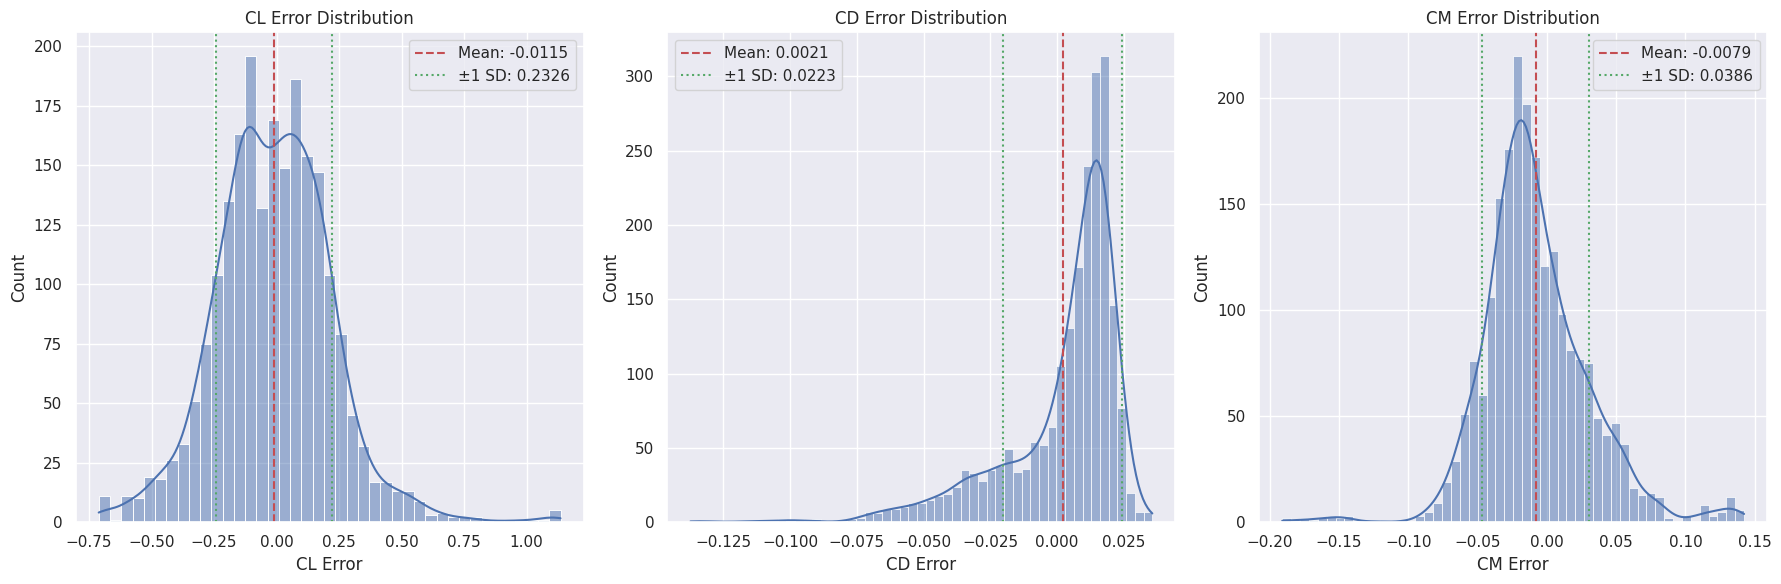

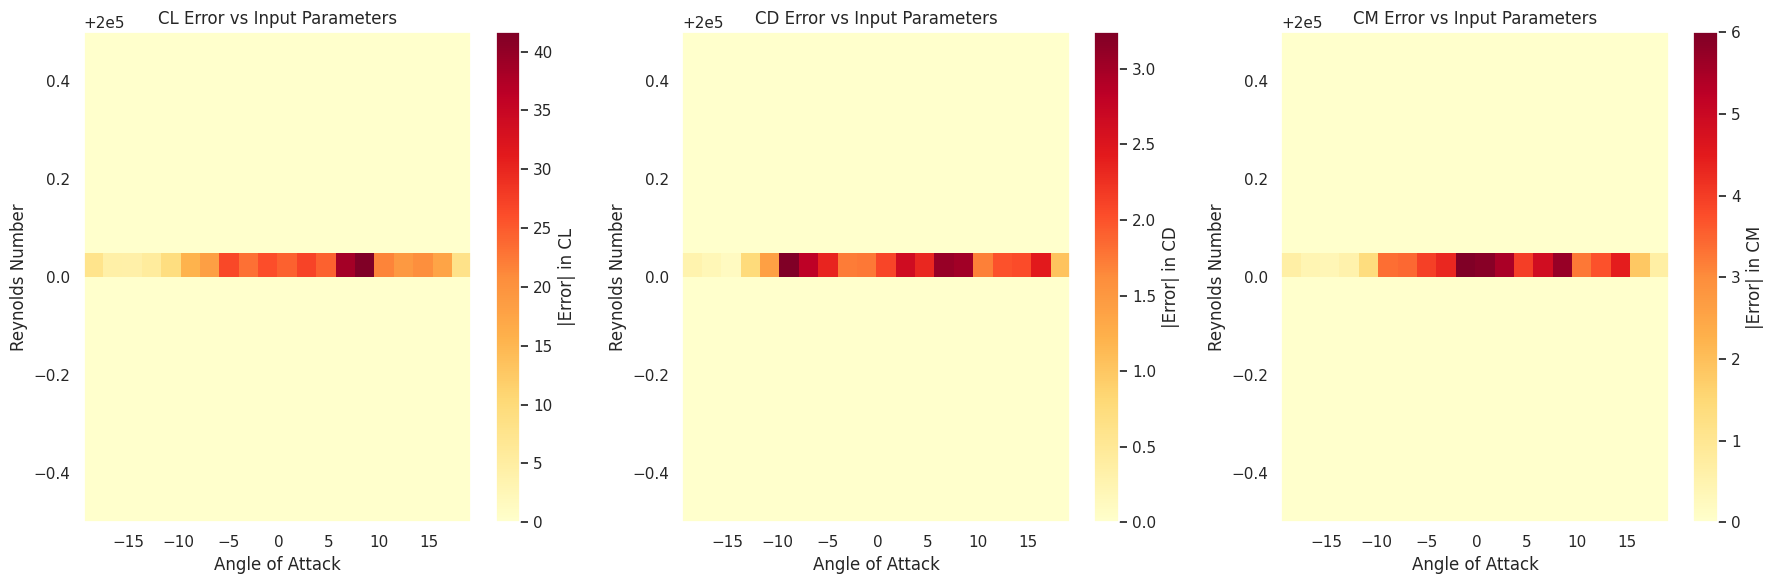


Mean Absolute Error:
CL: 0.1796
CD: 0.0173
CM: 0.0301

R² Scores:
CL: 0.8884
CD: 0.4146
CM: 0.3178


In [79]:
# Main execution
if __name__ == "__main__":
    # Load and prepare data
    dataset = AirfoilDataset('ConvData.csv')
    train_data, val_data = train_test_split(dataset, test_size=0.2, random_state=42)

    train_loader = DataLoader(train_data, batch_size=32, shuffle=True, collate_fn=collate_fn)
    val_loader = DataLoader(val_data, batch_size=32, shuffle=False, collate_fn=collate_fn)

    # Initialize model, loss function, and optimizer
    model = ImprovedAirfoilCNN()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = ReduceLROnPlateau(optimizer, 'min', patience=5, factor=0.5)

    # Train the model
    num_epochs = 40
    train_losses, val_losses, learning_rates = train_model(
        model, train_loader, val_loader, criterion, optimizer, scheduler, num_epochs
    )

    # Collect predictions and targets for visualization
    model.eval()
    all_predictions = []
    all_targets = []
    all_params = []

    with torch.no_grad():
        for inputs, params, targets in val_loader:
            inputs, params = inputs.to(device), params.to(device)
            outputs = model(inputs, params)
            all_predictions.extend(outputs.cpu().numpy())
            all_targets.extend(targets.numpy())
            all_params.extend(params.cpu().numpy())

    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_params = np.array(all_params)

    # Denormalize predictions and targets
    all_predictions_denorm = dataset.output_scaler.inverse_transform(all_predictions)
    all_targets_denorm = dataset.output_scaler.inverse_transform(all_targets)
    all_params_denorm = dataset.input_scaler.inverse_transform(all_params)

    # Prepare results dictionary
    model_results = {
        'train_losses': train_losses,
        'val_losses': val_losses,
        'learning_rates': learning_rates,
        'predictions': all_predictions_denorm,
        'targets': all_targets_denorm,
        'input_params': all_params_denorm
    }

    # Create visualizations
    # First, import the visualization functions from the previous code
    plot_loss_curves_with_lr(
        model_results['train_losses'],
        model_results['val_losses'],
        model_results['learning_rates']
    )

    coefficient_names = ['CL', 'CD', 'CM']
    plot_regression_analysis(
        model_results['predictions'],
        model_results['targets'],
        coefficient_names
    )

    plot_error_distribution(
        model_results['predictions'],
        model_results['targets'],
        coefficient_names
    )

    plot_performance_heatmap(
        model_results['predictions'],
        model_results['targets'],
        model_results['input_params'],
        coefficient_names
    )

    # Calculate and print mean absolute error for each coefficient
    mae = np.mean(np.abs(all_predictions_denorm - all_targets_denorm), axis=0)
    print("\nMean Absolute Error:")
    print(f"CL: {mae[0]:.4f}")
    print(f"CD: {mae[1]:.4f}")
    print(f"CM: {mae[2]:.4f}")

    # Calculate and print R² scores for each coefficient
    r2_scores = [r2_score(all_targets_denorm[:, i], all_predictions_denorm[:, i])
                 for i in range(3)]
    print("\nR² Scores:")
    print(f"CL: {r2_scores[0]:.4f}")
    print(f"CD: {r2_scores[1]:.4f}")
    print(f"CM: {r2_scores[2]:.4f}")